In [1]:
import configparser
config = configparser.ConfigParser()
config.read("config.properties")

APIKey = config.get("AzureCredentials","APIKey").strip()
Endpoint = config.get("AzureCredentials","Endpoint").strip()
Deployment = config.get("AzureCredentials","Deployment").strip()
version = config.get("AzureCredentials","version").strip()

Googlekey = config.get('GoogleCred','key')


# AZURE

In [3]:
from langchain_openai import AzureChatOpenAI

llm = AzureChatOpenAI(temperature = 0.2,
                                deployment_name=Deployment,
                                openai_api_version=version,
                                openai_api_key=APIKey, 
                                azure_endpoint=Endpoint)
llm.invoke("Hi")



AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 8, 'total_tokens': 17, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_5154047bf2', 'finish_reason': 'stop', 'logprobs': None, 'content_filter_results': {}}, id='run-90964c9b-7f85-4508-9ad9-8479f24f7ccd-0', usage_metadata={'input_tokens': 8, 'output_tokens': 9, 'total_tokens': 17, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

# AWS

In [60]:
from langchain_aws import ChatBedrock
import boto3
import requests
boto3.setup_default_session(
    **requests.get("http://localhost:8000/awscred").json()    
)

client = ""
llm = ""
def renew():
  global llm
  global client
  boto3.setup_default_session(
      **requests.get("http://localhost:8000/awscred").json()
  )
  client = boto3.client(service_name="bedrock-runtime",region_name="us-east-1")
  llm = ChatBedrock(model_id ="anthropic.claude-3-5-sonnet-20240620-v1:0",
                  client = client,
                  model_kwargs={"max_tokens":5000}
                  #   guardrails={"id": "xpqvrjzg8jpl", "version": "5"}
                  )
renew()
print(llm.invoke("HI , i am facing issue i this azure"))


content="Hello! I'm sorry to hear that you're facing an issue with Azure. To help you better, I'll need more specific information about the problem you're experiencing. Can you please provide more details about:\n\n1. What specific Azure service or feature are you using?\n2. What exactly is the issue you're encountering?\n3. Are you seeing any error messages? If so, what do they say?\n4. What steps have you already taken to try to resolve the issue?\n\nThe more information you can provide, the better I'll be able to assist you or guide you towards a solution." additional_kwargs={'usage': {'prompt_tokens': 17, 'completion_tokens': 129, 'total_tokens': 146}, 'stop_reason': 'end_turn', 'model_id': 'anthropic.claude-3-5-sonnet-20240620-v1:0'} response_metadata={'usage': {'prompt_tokens': 17, 'completion_tokens': 129, 'total_tokens': 146}, 'stop_reason': 'end_turn', 'model_id': 'anthropic.claude-3-5-sonnet-20240620-v1:0'} id='run-f66ded11-59c5-43ad-8344-f72c67150b15-0' usage_metadata={'inpu

In [61]:
from langchain_core.tools import tool
from langchain_community.document_transformers import Html2TextTransformer
from langchain_community.document_loaders import AsyncHtmlLoader
from langchain_community.utilities import GoogleSearchAPIWrapper
from duckduckgo_search import DDGS
import os

os.environ["GOOGLE_CSE_ID"] = config.get('GoogleCred','GOOGLE_CSE_ID')
os.environ["GOOGLE_API_KEY"] = config.get('GoogleCred','GOOGLE_API_KEY')

html2text = Html2TextTransformer()
from langchain_core.tools import Tool

def scrapeFromURLs(URLs):
    if isinstance(URLs,str):
        URLs = [URLs]
    loader = AsyncHtmlLoader(URLs,ignore_load_errors=True)
    docs = loader.load() 
    docs_transformed = html2text.transform_documents(docs)
    return docs_transformed


search = GoogleSearchAPIWrapper()
def TopGoogleResult(query):
    return search.results(query, 10)

# ______________________________________________________ DuckDuckGO
def top5_it_results(query):
    results = DDGS().text(query, max_results=10)
    return results

Gtool = Tool(
        name="Google Search Snippets",
        description="Search Google for problem's solution.",
        func=TopGoogleResult,
    )

def refactor(Docs):
    try:
        if isinstance(Docs,str):
            Docs = [Docs]
        _refactorList = []
        for doc in Docs:
            WebTemplate = f"""You are Advance refactor for web scrapped text and you give the most relevant information from the messy document ,here is the new web Ducument:'{doc}' , please provide only the relevant answer within 80 words for user question only ,response:"""
            _refactorList.append(llm.invoke(WebTemplate).content.replace('{','}').replace('}','{'))
        return _refactorList
    except Exception as e:
        print("Azure interuption.....")
        return [f"The website contains in appropriate data so it was filtered,guradrail interuption "]


def search_web(search_query):
    '''A websearch tool which search into web and accepts a web search query'''
    try:
        webpages_to_include = 3

        # structured_llm = llm.with_structured_output(SearchQuery)
        # search_query = structured_llm.invoke([search_instructions]+state['messages']).search_query
        
        Gresult = Gtool.run(search_query)
        Dtool = Tool(
            name="Google Search Snippets",
            description="Search Google for problem's solution.",
            func=top5_it_results,
        )
        # Dresult = Dtool.run(user_text) 

        allResult = Gresult #+ Dresult 
        web_URL = [website.get("link",website.get("href")) for website in allResult]
        web_URL =list(set(web_URL))
        idx = 0 
        document_list = []
        for _, URL in enumerate(web_URL):
            try:
                # WebPageData = refactor(scrapeFromURLs(URL))
                WebPageData = scrapeFromURLs(URL)
                document_list.append(
                    f"""URL:{URL} <document>{WebPageData} </documenet>"""
                )
                if WebPageData[0] in ['' ,None]:
                    continue
            except Exception as e :
                print(f"Skipping..........{e}")
                continue
            idx = idx + 1
            if webpages_to_include == idx:
                break
        print(document_list)
        return {"context": ["\n\n---\n\n".join(document_list)]} 
    except Exception as e:
        print(e)



In [62]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL


# This executes code locally, which can be unsafe
repl = PythonREPL()


@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code and do math. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return result_str

In [63]:
from typing import Literal
from typing_extensions import TypedDict

from langgraph.graph import MessagesState, END
from langgraph.types import Command

In [64]:
members = ["researcher", "coder"]
# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = members + ["FINISH"]

In [65]:
system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    f" following workers: {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)

In [66]:
class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""

    next: Literal[*options]

In [67]:
def supervisor_node(state: MessagesState) -> Command[Literal[*members, "__end__"]]:
    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]
    response = llm.with_structured_output(Router).invoke(messages)
    goto = response["next"]
    if goto == "FINISH":
        goto = END

    return Command(goto=goto)

In [68]:
from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import create_react_agent

In [69]:
research_agent = create_react_agent(
    llm, tools=[search_web], state_modifier="You are a researcher. DO NOT do any math."
)


In [70]:
def research_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    result = research_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="researcher")
            ]
        },
        goto="supervisor",
    )

In [71]:
code_agent = create_react_agent(llm, tools=[python_repl_tool])

In [72]:
def code_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    result = code_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="coder")
            ]
        },
        goto="supervisor",
    )


In [73]:
builder = StateGraph(MessagesState)
builder.add_edge(START, "supervisor")
builder.add_node("supervisor", supervisor_node)
builder.add_node("researcher", research_node)
builder.add_node("coder", code_node)
graph = builder.compile()

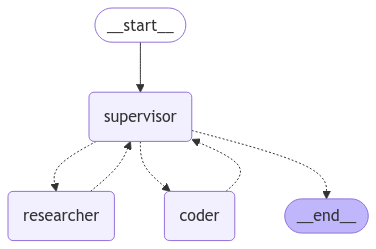

In [74]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [75]:
for s in graph.stream(
    {"messages": [("user", "What's is 8 * root(42)")]}, subgraphs=True
):
    print(s)
    print("----")

((), {'supervisor': None})
----
(('researcher:64161c1a-636e-ce15-589b-a983a9d723f3',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'usage': {'prompt_tokens': 385, 'completion_tokens': 161, 'total_tokens': 546}, 'stop_reason': 'tool_use', 'model_id': 'anthropic.claude-3-5-sonnet-20240620-v1:0'}, response_metadata={'usage': {'prompt_tokens': 385, 'completion_tokens': 161, 'total_tokens': 546}, 'stop_reason': 'tool_use', 'model_id': 'anthropic.claude-3-5-sonnet-20240620-v1:0'}, id='run-74d107cb-fbff-4d1b-9400-86d9e6212083-0', tool_calls=[{'name': 'search_web', 'args': {'search_query': 'calculate 8 * square root of 42'}, 'id': 'toolu_bdrk_01Df2ir7tKqa1nC2941X6vUY', 'type': 'tool_call'}], usage_metadata={'input_tokens': 385, 'output_tokens': 161, 'total_tokens': 546})]}})
----


Fetching pages: 100%|##########| 1/1 [00:00<00:00,  2.41it/s]


["URL:https://www.hpmuseum.org/cgi-sys/cgiwrap/hpmuseum/archv014.cgi?read=50931 <document>[Document(metadata={'source': 'https://www.hpmuseum.org/cgi-sys/cgiwrap/hpmuseum/archv014.cgi?read=50931'}, page_content='\\n\\n')] </documenet>", "URL:https://mathsolver.microsoft.com/en/solve-problem/%60sqrt%20%7B%2024%20%7D%20%60cdot%20%60sqrt%20%7B%2042%20%7D%20%60cdot%20%60sqrt%20%7B%206%20%7D <document>[Document(metadata={'source': 'https://mathsolver.microsoft.com/en/solve-problem/%60sqrt%20%7B%2024%20%7D%20%60cdot%20%60sqrt%20%7B%2042%20%7D%20%60cdot%20%60sqrt%20%7B%206%20%7D', 'title': 'Solve sqrt{24}*sqrt{42}*sqrt{6} | Microsoft Math Solver', 'description': 'Solve your math problems using our free math solver with step-by-step solutions. Our math solver supports basic math, pre-algebra, algebra, trigonometry, calculus and more.', 'language': 'en'}, page_content='Skip to main content\\n\\nMicrosoft|Math Solver\\n\\nSolvePracticePlay\\n\\n## Topics\\n\\n _\\ue70d_ Pre-Algebra\\n\\n  * Mean

In [76]:
for s in graph.stream(
    {
        "messages": [
            (
                "user",
                "Find the latest GDP of New York and California, then calculate the average",
            )
        ]
    },
    subgraphs=True,
):
    print(s)
    print("----")

((), {'supervisor': None})
----
(('researcher:c6aec312-e4cf-783e-ce7a-c6044b7c53e3',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'usage': {'prompt_tokens': 388, 'completion_tokens': 109, 'total_tokens': 497}, 'stop_reason': 'tool_use', 'model_id': 'anthropic.claude-3-5-sonnet-20240620-v1:0'}, response_metadata={'usage': {'prompt_tokens': 388, 'completion_tokens': 109, 'total_tokens': 497}, 'stop_reason': 'tool_use', 'model_id': 'anthropic.claude-3-5-sonnet-20240620-v1:0'}, id='run-6f584fe5-596c-43ca-a623-44b2596673bb-0', tool_calls=[{'name': 'search_web', 'args': {'search_query': 'latest GDP of New York state'}, 'id': 'toolu_bdrk_018vc8D44xBpYUxXppAfWv7X', 'type': 'tool_call'}], usage_metadata={'input_tokens': 388, 'output_tokens': 109, 'total_tokens': 497})]}})
----


Fetching pages: 100%|##########| 1/1 [00:01<00:00,  1.38s/it]


['URL:https://www.budget.ny.gov/ <document>[Document(metadata={\'source\': \'https://www.budget.ny.gov/\', \'title\': \'New York State Division of the Budget Home\', \'language\': \'en\'}, page_content="skip navigation\\n\\nNavigation menu\\n\\n# Division of the Budget\\n\\n  * Budget Applications\\n    * Budget Applications Home\\n    * Secure Login for Budget Applications\\n    * Outlook Web Access\\n    * Employee Portal\\n    * BAPS\\n  * State Agency Guide\\n    * State Agency Guide Home\\n    * Budget Bulletins\\n    * Budget Request Manual\\n  * Publications\\n    * Publications Home\\n    * FY 2025 Enacted Budget\\n    * FY 2025 Executive Budget\\n    * FY 2025 Budget Publications\\n    * FY 2024 Enacted Budget\\n    * FY 2024 Budget Publications\\n    * Budget Publications Archive\\n    * Financial Plans\\n    * Capital Program and Financing Plans\\n    * Descriptions of School Programs\\n    * Annual Reports on Tax Expenditures\\n    * Supplementary Budget Documents\\n    * P

Fetching pages: 100%|##########| 1/1 [00:00<00:00,  1.12it/s]


["URL:https://usafacts.org/metrics/gross-domestic-product-gdp-by-state-california/ <document>[Document(metadata={'source': 'https://usafacts.org/metrics/gross-domestic-product-gdp-by-state-california/', 'title': 'Economy in the United States for Gross Domestic Product (gdp) (Metrics), California (State): Data and Trends | USAFacts', 'description': 'USAFacts -- In 2022 (most recent), Gross domestic product (GDP) was 3598102700000.0 in the United States for California (state). This increased by 224,862,000,000 or 6.67% from 2021. Highest: 3,598,102,700,000 in 2022. Lowest: 1,071,117,000,000 in 1997.', 'language': 'en'}, page_content='  * Economy\\n  * Crime\\n  * Education\\n  * Health\\n  * Population\\n  * About\\n  * More\\n\\nSubscribe\\n\\n  1. Home\\n\\n  2. /\\n\\n  3.   4. /\\n\\n  5. California\\n\\n  1. Home\\n\\n  2. /\\n\\n  3. Economy\\n\\n  4. /\\n\\n  5. Metrics\\n\\n  6. /\\n\\n  7. Gross domestic product (GDP)\\n\\n  8. /\\n\\n  9. By state\\n\\n  10. /\\n\\n  11. Califo

Fetching pages: 100%|##########| 1/1 [00:00<00:00,  1.03it/s]


['URL:https://newsroom.bankofamerica.com/content/newsroom/press-releases/2024/08/inaugural-u-s--latina-gdp-report-finds-latinas-contribute--1-3-t.html <document>[Document(metadata={\'source\': \'https://newsroom.bankofamerica.com/content/newsroom/press-releases/2024/08/inaugural-u-s--latina-gdp-report-finds-latinas-contribute--1-3-t.html\', \'title\': \'Inaugural U.S. Latina GDP Report Finds Latinas Contribute $1.3 Trillion in GDP\', \'description\': \'New data from leading researchers indicates that female Hispanics in the U.S. have contributed $1.3 trillion in 2021 to the gross domestic product (GDP), representing over 50% growth in a decade. The U.S. Latina GDP Report, funded by Bank of America, is first of its kind research on the significant and rapidly growing economic contribution of the nation’s Hispanic female population.\', \'language\': \'en-US\'}, page_content=\'Skip to main content\\n\\nMain menu\\n\\nNewsroom\\n\\n  *   *   *   * \\n\\n  *   *   *   * \\n\\nSearch\\n\\nCo

Fetching pages: 100%|##########| 1/1 [00:00<00:00, 10.15it/s]


['URL:https://newsroom.bankofamerica.com/content/newsroom/press-releases/2024/08/inaugural-u-s--latina-gdp-report-finds-latinas-contribute--1-3-t.html <document>[Document(metadata={\'source\': \'https://newsroom.bankofamerica.com/content/newsroom/press-releases/2024/08/inaugural-u-s--latina-gdp-report-finds-latinas-contribute--1-3-t.html\', \'title\': \'Inaugural U.S. Latina GDP Report Finds Latinas Contribute $1.3 Trillion in GDP\', \'description\': \'New data from leading researchers indicates that female Hispanics in the U.S. have contributed $1.3 trillion in 2021 to the gross domestic product (GDP), representing over 50% growth in a decade. The U.S. Latina GDP Report, funded by Bank of America, is first of its kind research on the significant and rapidly growing economic contribution of the nation’s Hispanic female population.\', \'language\': \'en-US\'}, page_content=\'Skip to main content\\n\\nMain menu\\n\\nNewsroom\\n\\n  *   *   *   * \\n\\n  *   *   *   * \\n\\nSearch\\n\\nCo

Fetching pages: 100%|##########| 1/1 [00:00<00:00,  8.02it/s]


['URL:https://www.budget.ny.gov/ <document>[Document(metadata={\'source\': \'https://www.budget.ny.gov/\', \'title\': \'New York State Division of the Budget Home\', \'language\': \'en\'}, page_content="skip navigation\\n\\nNavigation menu\\n\\n# Division of the Budget\\n\\n  * Budget Applications\\n    * Budget Applications Home\\n    * Secure Login for Budget Applications\\n    * Outlook Web Access\\n    * Employee Portal\\n    * BAPS\\n  * State Agency Guide\\n    * State Agency Guide Home\\n    * Budget Bulletins\\n    * Budget Request Manual\\n  * Publications\\n    * Publications Home\\n    * FY 2025 Enacted Budget\\n    * FY 2025 Executive Budget\\n    * FY 2025 Budget Publications\\n    * FY 2024 Enacted Budget\\n    * FY 2024 Budget Publications\\n    * Budget Publications Archive\\n    * Financial Plans\\n    * Capital Program and Financing Plans\\n    * Descriptions of School Programs\\n    * Annual Reports on Tax Expenditures\\n    * Supplementary Budget Documents\\n    * P

Fetching pages: 100%|##########| 1/1 [00:00<00:00,  9.28it/s]


['URL:https://www.budget.ny.gov/ <document>[Document(metadata={\'source\': \'https://www.budget.ny.gov/\', \'title\': \'New York State Division of the Budget Home\', \'language\': \'en\'}, page_content="skip navigation\\n\\nNavigation menu\\n\\n# Division of the Budget\\n\\n  * Budget Applications\\n    * Budget Applications Home\\n    * Secure Login for Budget Applications\\n    * Outlook Web Access\\n    * Employee Portal\\n    * BAPS\\n  * State Agency Guide\\n    * State Agency Guide Home\\n    * Budget Bulletins\\n    * Budget Request Manual\\n  * Publications\\n    * Publications Home\\n    * FY 2025 Enacted Budget\\n    * FY 2025 Executive Budget\\n    * FY 2025 Budget Publications\\n    * FY 2024 Enacted Budget\\n    * FY 2024 Budget Publications\\n    * Budget Publications Archive\\n    * Financial Plans\\n    * Capital Program and Financing Plans\\n    * Descriptions of School Programs\\n    * Annual Reports on Tax Expenditures\\n    * Supplementary Budget Documents\\n    * P

Fetching pages: 100%|##########| 1/1 [00:01<00:00,  1.16s/it]


["URL:https://www.osc.ny.gov/files/reports/pdf/profile-of-agriculture-in-nys.pdf <document>[Document(metadata={'source': 'https://www.osc.ny.gov/files/reports/pdf/profile-of-agriculture-in-nys.pdf', 'title': 'Just a moment...', 'language': 'en-US'}, page_content='Enable JavaScript and cookies to continue\\n\\n')] </documenet>", "URL:https://www.osc.ny.gov/reports/economic-impact-great-outdoors <document>[Document(metadata={'source': 'https://www.osc.ny.gov/reports/economic-impact-great-outdoors', 'title': 'Just a moment...', 'language': 'en-US'}, page_content='Enable JavaScript and cookies to continue\\n\\n')] </documenet>", 'URL:https://www.bea.gov/data/special-topics/outdoor-recreation <document>[Document(metadata={\'source\': \'https://www.bea.gov/data/special-topics/outdoor-recreation\', \'title\': \'Outdoor Recreation | U.S. Bureau of Economic Analysis (BEA)\', \'description\': \'\\xa0 \\xa0Browse the MapGet an overview of outdoor recreation economic activity across all 50 states 